1.555721387919415
0.43952811302310857
0.9976247504712616
1.5334434231549994
0.986485768089054
1.2220291342410905
1.377736278698045


C:\Users\gabriel\AppData\Local\Temp\ipykernel_2396\3725074028.py:29: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  gaussian_points = np.random.multivariate_normal(mean, cov, points_per_gaussian)


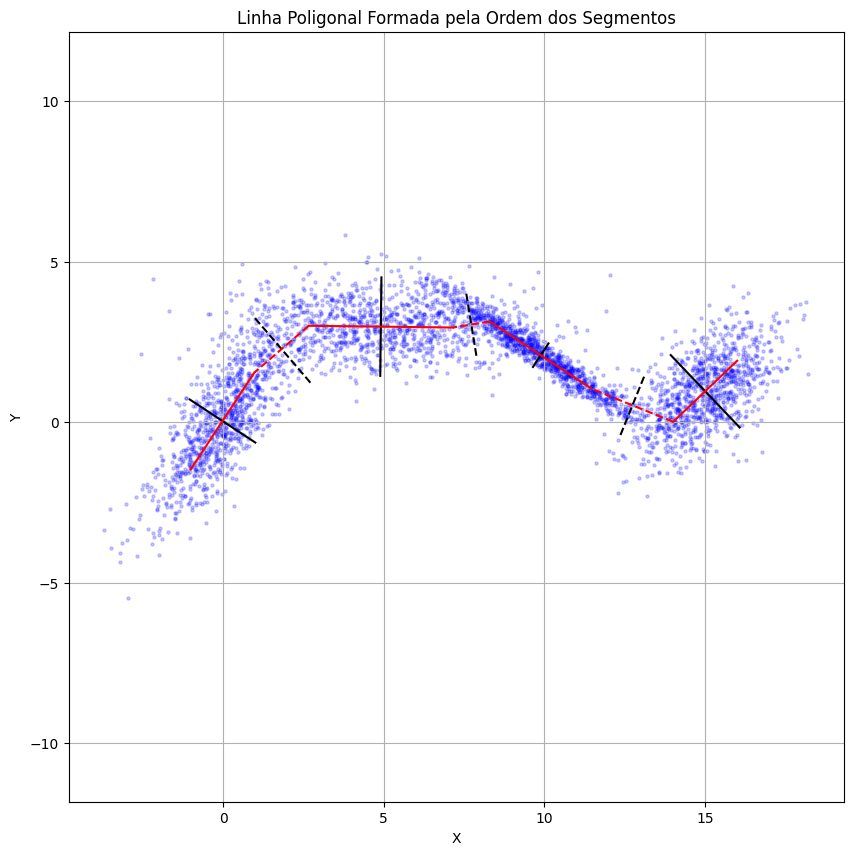

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.interpolate import interp1d

# Configurações das gaussianas
np.random.seed(42)  # Para reprodutibilidade
num_gaussians = 5
points_per_gaussian = 1000

# Parâmetros de cada gaussiana (média e covariância)
means = [
    [0, 0],
    [5, 3],
    [10, 2],
    [15, 1],
]

covariances = [
    [[2, 3], [0, 0.5]],
    [[5,0], [0.2, 0.5]],
    [[3, -2], [0, 0]],
    [[1.2, 0.6], [0.6, 1]],
]

# Gerar os dados
data = []
for mean, cov in zip(means, covariances):
    gaussian_points = np.random.multivariate_normal(mean, cov, points_per_gaussian)
    data.append(gaussian_points)

data = np.vstack(data)

# Adicionar ruído
noise = np.random.normal(0, 0.2, data.shape)
data_with_noise = data + noise


def gmm_principal_curve(data, n_components=5):
    """
    Approximate a principal curve using a Gaussian Mixture Model.
    
    Parameters:
    - data: np.ndarray, shape (n_samples, n_features)
      Input data.
    - n_components: int
      Number of Gaussian components in the GMM.
    - n_points: int
      Number of points to sample on the principal curve.

    Returns:
    - curve: np.ndarray, shape (n_points, n_features)
      The computed principal curve.
    """
    # Fit GMM to the data
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(data)

    # Extract means of the GMM components
    means = gmm.means_
    covariances = gmm.covariances_
        
    # Sort means along a principal axis (e.g., first component)
    sort_indices = np.argsort(means[:, 0])
    means_sorted = means[sort_indices]
    covariances_sorted = covariances[sort_indices]
    
    pcs_ortogonal = []
    curve = []
    for i, mean in enumerate(means_sorted):
        # Compute PCA on the covariance matrix
        eigvals, eigvecs = np.linalg.eigh(covariances_sorted[i])
        
        # Take the second principal component
        std_dev0 = np.sqrt(eigvals[0]) 
        direction0 = eigvecs[:, 0]    
        std_dev1 = np.sqrt(eigvals[1]) 
        direction1 = eigvecs[:, 1]    
        
        # Ajuste usando o desvio padrão, verificar qual o melhor valor para que tenha um grau de confiança. Isso deve ser documentado na lib
        scaled_direction0 = 1.5 * np.sqrt(2) * std_dev0 * direction0
        scaled_direction1 = std_dev1 * direction1
        
        # Save ellipse data
        pcs_ortogonal.append({
            'center': mean,
            'direction': direction0,
            'scaled_direction': scaled_direction0
        })
        curve.append({
            'center': mean,
            'direction': direction1,
            'scaled_direction': scaled_direction1
        })
    
    return curve, pcs_ortogonal
K = 4
# import pandas as pd 
# file_path = '../data/spiral_data.csv'  # Update the path if necessary
# spiral_data = pd.read_csv(file_path)

# # Extract x and y coordinates
# x_data = spiral_data['x']
# y_data = spiral_data['y']
# data_with_noise = np.column_stack((x_data, y_data))
curve, ortogonal_components = gmm_principal_curve(data_with_noise, K)
    
# # Plotar os dados
# plt.figure(figsize=(10, 6))
# plt.scatter(data_with_noise[:, 0], data_with_noise[:, 1], s=10, alpha=0.5, c='blue')
# plt.title("Dados Sintéticos com Gaussianas Alongadas")
# plt.xlabel("Dimensão 1")
# plt.ylabel("Dimensão 2")
# plt.grid(True)

points_shuffled = np.zeros((2*len(curve), 2))
for i, seg in enumerate(curve):
    center_seg = seg['center']
    scaled_direction_seg = seg['scaled_direction']
    points_shuffled[2*i] = np.array([center_seg + scaled_direction_seg])
    points_shuffled[2*i+1] = np.array([center_seg - scaled_direction_seg])

from scipy.spatial.distance import cdist

'''
Ordena Segmentos e também a componente principal ortogonal  
'''
segments = points_shuffled.reshape(len(points_shuffled) // 2, 2, 2)
# Lista para armazenar a ordem dos segmentos
ordered_segments = []

# Usar o primeiro segmento como ponto inicial
current_segment = segments[0]
ordered_segments.append(current_segment)
ordered_pcs = [ortogonal_components[0]]
current_start, current_end = current_segment

# Criar uma lista dos segmentos restantes
remaining_segments = list(segments[1:])
remaining_pcs = list(ortogonal_components[1:])

plt.figure(figsize=(10, 10))

while remaining_segments:
    # Criar uma lista com todos os extremos dos segmentos restantes
    candidates = []
    for seg in remaining_segments:
        candidates.extend(seg)
    candidates = np.array(candidates)
    
    # Calcular a menor distância entre o ponto final do segmento atual e os candidatos
    distances_end = cdist([current_end], candidates)
    distances_start = cdist([current_start], candidates)
    min_idx_end = np.argmin(distances_end)
    min_dist_end = np.min(distances_end)
    min_idx_start = np.argmin(distances_start)
    min_dist_start = np.min(distances_start)
    
    if min_dist_start > min_dist_end:  
        next_segment_idx = min_idx_end // 2
        next_segment = remaining_segments[next_segment_idx]
        ordered_pcs.append(remaining_pcs[next_segment_idx])
        if min_idx_end % 2 == 0:
            current_end = next_segment[1] 
            ordered_segments.append(next_segment)
        else:
            current_end = next_segment[0] 
            ordered_segments.append([next_segment[1], next_segment[0]])
              
    else:
        next_segment_idx = min_idx_start // 2
        next_segment = remaining_segments[next_segment_idx]
        ordered_pcs.insert(0, remaining_pcs[next_segment_idx])
        if min_idx_start % 2 == 0:
            current_start = next_segment[1] 
            ordered_segments.insert(0, [next_segment[1], next_segment[0]])
        else:
            current_start = next_segment[0] 
            ordered_segments.insert(0, next_segment)
        
    # Remover o segmento já utilizado
    del remaining_segments[next_segment_idx]
    del remaining_pcs[next_segment_idx]

ordered_segments = np.array(ordered_segments)

final_curve = []

def calc_ort_line(segment_obj):
    return np.array([
        segment_obj['center'] + segment_obj['scaled_direction'],
        segment_obj['center'] - segment_obj['scaled_direction']
    ])
def calc_connection_seg(seg_prev, pc_prev, seg_current, pc_current):
    center = (seg_prev[1] + seg_current[0]) / 2;
    pc_norm = (np.linalg.norm(pc_current['scaled_direction']) + np.linalg.norm(pc_prev['scaled_direction'])) / 2
    
    conn_seg = seg_prev[1] - seg_current[0]
    seg_x, seg_y = conn_seg
    pc_dir = [seg_y, -seg_x]/ np.linalg.norm(conn_seg)
    ort_line = calc_ort_line({ 'center': center, 'scaled_direction': pc_dir * pc_norm })
    return {
        'ortogonal_pc': ort_line,
        'max_dist': pc_norm,
        'seg_points': np.array([seg_prev[1], seg_current[0]]),
        'is_conn': True
    }
    
    
for i, segment in enumerate(ordered_segments):
    current_ortogonal_pc = calc_ort_line(ordered_pcs[i])                 
    final_curve.append({
        'max_dist': np.linalg.norm(current_ortogonal_pc[1] - current_ortogonal_pc[0]) / 2,
        'ortogonal_pc': current_ortogonal_pc,
        'seg_points': segment,
        'is_conn': False
    }) 
    if (i>=1 and i < len(ordered_segments)):
        conn_seg = calc_connection_seg(ordered_segments[i-1], ordered_pcs[i-1], segment, ordered_pcs[i])        
        # append connection segment to the curve 
        final_curve.append(conn_seg)

'''
Plot data:
'''
plt.scatter(data_with_noise[:, 0], data_with_noise[:, 1], s=20, alpha=0.2, c='blue', marker='.')
for final_seg in final_curve:
    linestyle='--' if final_seg['is_conn'] else '-'
    print(final_seg['max_dist'])
    plt.plot(final_seg['ortogonal_pc'][:,0], final_seg['ortogonal_pc'][:,1], linestyle, color='black')
    plt.plot(final_seg['seg_points'][:,0], final_seg['seg_points'][:,1], linestyle, color='red')

plt.title('Linha Poligonal Formada pela Ordem dos Segmentos')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis("equal")
plt.grid()
plt.show()

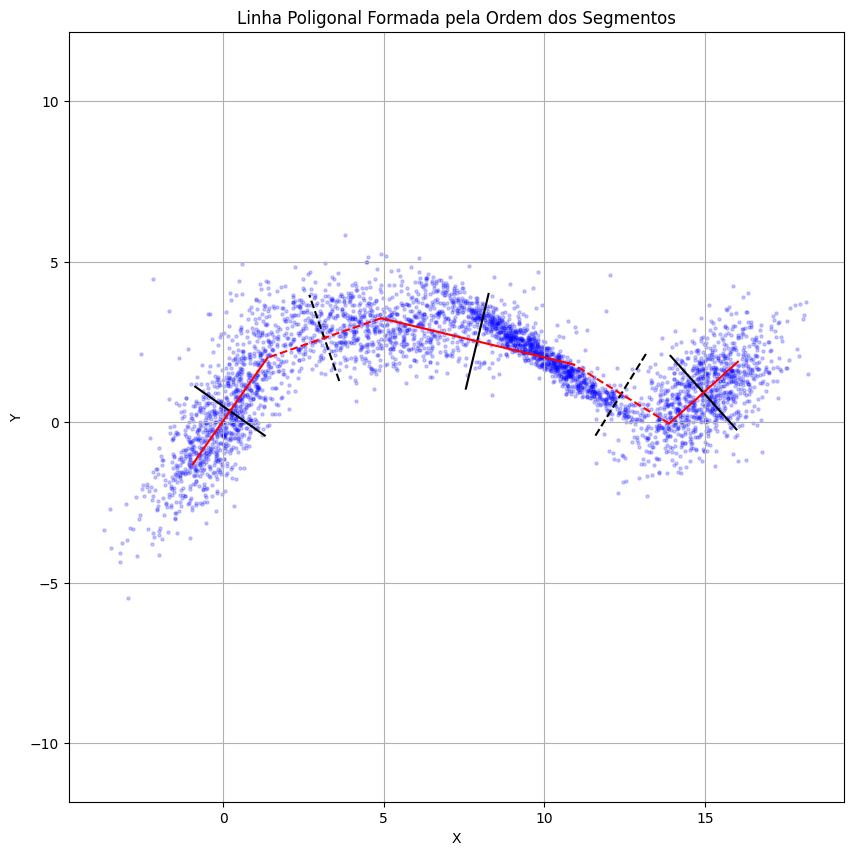

In [ ]:
def min_distances_and_indices(points, segments):
    """
    Calculate the minimum distance from each point to multiple segments and store the segment index.

    Parameters:
    - points: Array of shape (n, d), where each row is a point in N-dimensional space.
    - segments: Array of shape (m, 2, d), where each segment is defined by two points.

    Returns:
    - min_distances: Array of shape (n,), where each entry is the minimum distance for a point.
    - segment_indices: Array of shape (n,), where each entry is the index of the closest segment.
    """
    points = np.array(points)  # Shape: (n, d)
    segments = np.array(segments)  # Shape: (m, 2, d)

    a = segments[:, 0, :]  # Start points of segments, shape: (m, d)
    b = segments[:, 1, :]  # End points of segments, shape: (m, d)

    # Vector from A to B (segment direction vectors), shape: (m, d)
    ab = b - a

    # Squared length of each segment, shape: (m,)
    ab_len_sq = np.sum(ab**2, axis=1)

    # Expand points to shape (n, m, d)
    p_exp = points[:, np.newaxis, :]  # Shape: (n, 1, d)
    a_exp = a[np.newaxis, :, :]  # Shape: (1, m, d)
    ab_exp = ab[np.newaxis, :, :]  # Shape: (1, m, d)

    # Vector from A to P, shape: (n, m, d)
    ap = p_exp - a_exp

    # Projection factors (t values), shape: (n, m)
    t = np.sum(ap * ab_exp, axis=2) / ab_len_sq

    # Clamp t to the range [0, 1]
    t = np.clip(t, 0, 1)

    # Closest points on the segments, shape: (n, m, d)
    closest_points = a_exp + t[:, :, np.newaxis] * ab_exp

    # Distances from points to the closest points on each segment, shape: (n, m)
    distances = np.linalg.norm(p_exp - closest_points, axis=2)

    # Minimum distances and corresponding segment indices
    min_distances = np.min(distances, axis=1)
    segment_indices = np.argmin(distances, axis=1)

    return min_distances, segment_indices

#
points_validation = np.array([[10, 1], [4, 1.7]]) 
segments = np.array([seg['seg_points'] for seg in final_curve])

min_distances, segment_indices = min_distances_and_indices(points_validation, segments)

print("Minimum Distances:", min_distances)
print("Segment Indices:", segment_indices)
isFromClass = [final_curve[idx]['max_dist'] >= min_distances[i]  for i, idx in enumerate(segment_indices)]
print(isFromClass)

Minimum Distances: [0.8470101  1.28868547]
Segment Indices: [1 3]
[np.False_, np.True_]
